In [2]:
!pip install qiskit

     |████████████████████████████████| 2.9MB 2.9MB/s 
     |████████████████████████████████| 23.1MB 5.1MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 1.8MB 38.6MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 5.6MB 29.2MB/s 
     |████████████████████████████████| 153kB 41.0MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
     |████████████████████████████████| 573kB 42.3MB/s 
     |████████████████████████████████| 24.3MB 1.3MB/s 
     |████████████████████████████████| 2.3MB 28.2MB/s 
  Created wheel for qiskit: filename=qiskit-0.15.0-cp36-none-any.whl size=1401 sha256=6a4e7b0720efb06423d44bee22520179f40de54d7193910662cd8d830e300338
  Stored in directory: /root/.cache/pip/wheels/9b/41/c1/95092efa209b6670db

## Probabilistic Quantum Memory


A probabilistic quantum memory is a memory based on the quantum propertiers allowing an exponential storange capacity. It uses entanglement, where each pattern in memory is storaged in a uniform superposition. It was also an retrieval method able to recovery the exactly pattern with an high probability.

In [0]:
from qiskit import QuantumRegister, QuantumCircuit, Aer, execute, ClassicalRegister
from qiskit.quantum_info.operators import Operator
import math

### Building a PQM

To build a pqm we need to have a uniform superposition such that:

$$|M\rangle = \frac{1}{\sqrt{p}}\sum_{i=1}^p|p^i\rangle~~~~~~~~~~~~~~~~~~~~(1)$$

This uniform superposition is obtained using three types of registers. The **pattern register** (p) where the pattern is immidiately, the **utility qubit** (u) which controls the entry of a new pattern in the memory and the **memory register** (m) itself. 

The register p of size *n* stores the pattern $p^i$. We also need a utility register u $|01\rangle$, finally a register m of *n* qubits will hold the memory.

$$|\psi_0^1\rangle = |p_1^1, \dots p_n^1;01;0_1,\dots, 0_n\rangle~~~~~~~~(2)$$

**PS: Quantum Circuits a reading from right to the left.**

In [84]:
n = 2 #pattern size

q_pattern = QuantumRegister(n, name='p') # pattern qubit
q_utility = QuantumRegister(2, name='u') # utility qubit
q_memory = QuantumRegister(n, name='m') # memory qubit

memory_circ = QuantumCircuit(q_pattern, q_utility, q_memory) # Memory circuit

data = [[0, 0], [1, 0]]
r = len(data) # Number of patterns

memory_circ.x(q_utility[1])




Afterward we need to load the patterns in the quantum registers. Then, we use the following subrotine:

$$|\psi_1^i\rangle = \prod_{j = 1}^{n} 2XOR_{p_ju_2m_j}|\psi_0^i\rangle~~~~~~~~~~~~(3)$$ 

The 2XOR operator is simply a Toffoli gate where the pattern qubit and the second utility qubit are the control and the memory qubit is the target. Therefore, the XOR is simply a CNOT gate.

$$|\psi_2^i\rangle = \prod_{j = 1}^{n} NOT_{m_j} XOR_{p_jm_j}|\psi_1^i\rangle$$ 

$$|\psi_3^i\rangle = nXOR_{m_j\dots m_n u_1}|\psi_2^i\rangle~~~~~~~~~~(4)$$ 

The first operation transforms the qubits of memory register one if they are equal to the pattern register. Both operation change the first utility qubit to $|1\rangle$.

The following operation is the crux moment of the algorithm it steps the amplitude of the register that will carry the values in the memory. That step is accomplished using the following operation:
$$ CS_{u_1u_2}^{p+1-i}|\psi_3^i\rangle~~~~~~~~~~~~~~~~~~~~(5)$$ 

where the $S^k$ matrix is given by:

$$
S^k =
\Bigg(\begin{matrix}
\sqrt{\frac{k-1}{k}} & \frac{1}{\sqrt{k}} \\
\frac{-1}{\sqrt{k}} & \sqrt{\frac{k-1}{k}}
\end{matrix}\Bigg)
$$

In [0]:
def csi(circuit, control, target, i):
  cs = Operator([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, math.sqrt((i-1)/i), 1/math.sqrt(i)],
    [0, 0, -1/math.sqrt(i), math.sqrt((i-1)/i)]
    ])
  circuit.unitary(cs, [target, control], label='cs')

1
2


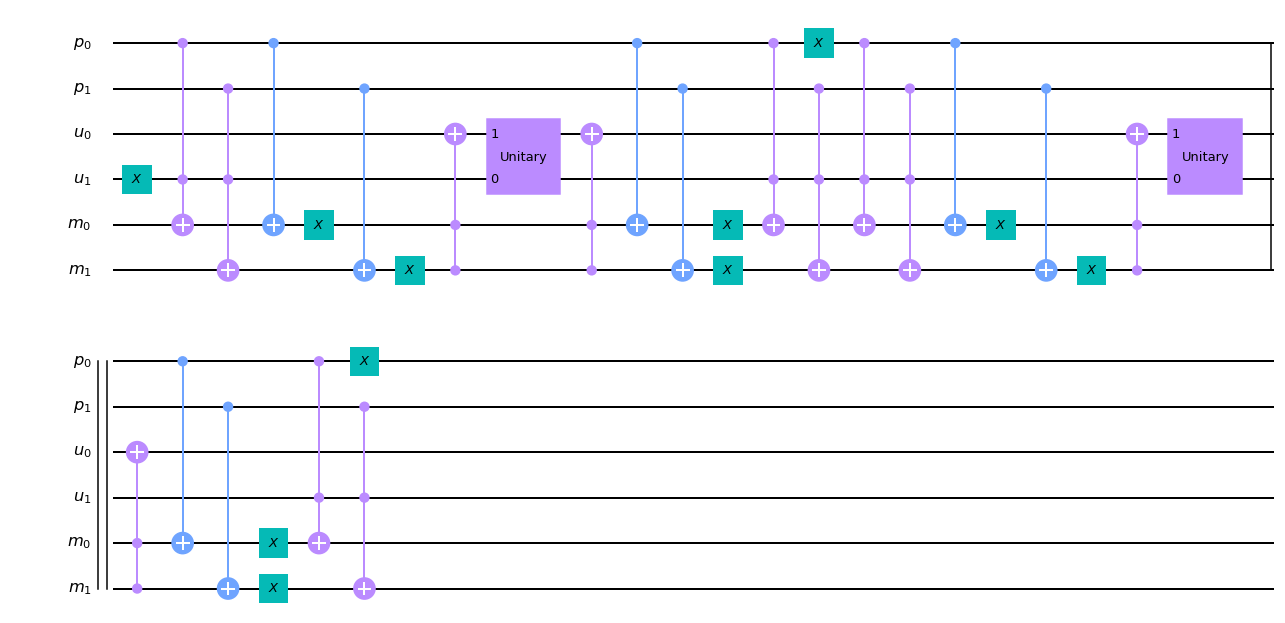

In [86]:

for  i, patterns in enumerate(data, start=1):

  index_one = [b for b, bit in enumerate(patterns) if bit is 1]
  for b in index_one: # Loading pattern in quantum register
    memory_circ.x(q_pattern[b])

  for p, m in zip(q_pattern, q_memory): 
    # Coping the the pattern from the pattern register to 
    memory_circ.ccx(p, q_utility[1], m) # the memory register using the utility qubit to control i

  for p, m in zip(q_pattern, q_memory):
    memory_circ.cx(p, m)
    memory_circ.x(m)

  memory_circ.mct(q_memory, q_utility[0], None, mode="noancilla")
  
  csi(memory_circ, q_utility[0], q_utility[1], r+1-i)
  
  memory_circ.mct(q_memory, q_utility[0], None, mode="noancilla")
  
  for p, m in zip(q_pattern, q_memory):
    memory_circ.cx(p, m)
    memory_circ.x(m)
  
  for p, m in zip(q_pattern, q_memory):
    memory_circ.ccx(p, q_utility[1], m)
  
  for b in index_one: # unloading pattern in quantum register
    memory_circ.x(q_pattern[b])
  print(i)
  
memory_circ.draw(output='mpl')   

## Retrieving Information


The process of retrieving information also requires three registers, the register $|i\rangle$, the memory $|m\rangle$ and finally a control register $|c\rangle$ in the state $\bigg(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\bigg)$. This form, the initial state consists of:

$$|\psi_0\rangle = 
\frac{1}{\sqrt{2p}}\sum_{k=1}^{p}|i_1,\dots i_n;p_1^k,\dots,p_n^k;0\rangle +
\frac{1}{\sqrt{2p}}\sum_{k=1}^{p}|i_1,\dots i_n;p_1^k,\dots,p_n^k;1\rangle
$$

In [87]:
# Here we use one of the utility qubits as the register c and
q_control = q_utility[0]
memory_circ.h(q_control)

In [88]:
 #we use the pattern register as input register
 q_input = q_pattern
 # We want to recover the pattern 01 in this example
 memory_circ.x(q_input[1])

## Now we apply the following combination:

$$|\psi_1\rangle = \prod_{k=1}^{n}NOT_{m_k}XOR_{i_km_K}|\psi_0\rangle~~~~~~~~~~~~6$$

It will result in the following state:

$$\frac{1}{\sqrt{2p}}\sum_{k=1}^{p}|i_1,\dots i_n;d_1^k,\dots,d_n^k;0\rangle +
\frac{1}{\sqrt{2p}}\sum_{k=1}^{p}|i_1,\dots i_n;d_1^k,\dots,d_n^k;1\rangle$$

Now, $d_j^k = 1$ "if and only if both $i_j = m_j$ and 0 otherwise". 

In [0]:
for i, m in zip(q_input, q_memory):
  memory_circ.cx(i, m)
  memory_circ.x(m)

Considering the operator $\mathcal{H}$ as follow:

$$\mathcal{H} = (d_H)_m\otimes(\sigma_3)_c$$,

$$dH_m = \sum_{k=1}^{n}\bigg(\frac{\sigma_3 + 1}{2}\bigg)_{m_k}$$

The operator $\sigma_3$ is known as the third Pauli matrix.


Now the $|\psi_2\rangle$ is given by:


$$|\psi_2\rangle = e^{i\frac{\pi}{2n}\mathcal{H}}|\psi_1\rangle$$

$$|\psi_2\rangle = \frac{1}{\sqrt{2p}}\sum_{k=1}^{p}e^{i\frac{\pi}{2n}d_H(i, p^k)}|i_1,\dots i_n;d_1^k,\dots,d_n^k;0\rangle $$

$$+ \frac{1}{\sqrt{2p}}\sum_{k=1}^{p}e^{-i\frac{\pi}{2n}d_H(i, p^k)}|i_1,\dots i_n;d_1^k,\dots,d_n^k;1\rangle$$

The $d_H(i, p^k)$ terms is simply the distance between the parttern $p^k$ in the memory and the input $i$.

It calculates the hamming distance bewteen the input and stored pattern in store it in the amplitude of the qubits registers.


This operation is accomplished using the following $U$ operator (or $\exp(i\pi\mathcal{H}/2n$)):

$$
U =
\bigg(
\begin{matrix}
e^{i\frac{\pi}{2n}} & 0 \\
0 & 1 \\
\end{matrix}
\bigg)
$$


Then, the whole operation is descriebed as:
$$|\psi_2\rangle = e^{i\frac{\pi}{2n}\mathcal{H}}|\psi_1\rangle$$
$$e^{i\frac{\pi}{2n}\mathcal{H}}|\psi_1\rangle = \prod_{i=1}^{n}(CU^{-2})_{cm_j}
\prod_{j=1}^{n}U_{mj}|\psi_1\rangle$$


In [0]:
for m in q_memory:
  memory_circ.u1(math.pi/(2*n), m)

for m in q_memory:
  memory_circ.cu1(-math.pi/n, q_control, m)

Finally, we apply these operation.

$$|\psi_3\rangle = H_c\prod_{k=n}^{1}XOR_{i_km_k}NOT_{mk}|\psi_2\rangle$$


 At the end we will have the state:

 $$|\psi_3\rangle =\frac{1}{\sqrt{2p}}\sum_{k=1}^{p}cos\frac{\pi}{2n}d_H(i,p^k)|i_1,\dots i_n;d_1^k,\dots,d_n^k;0\rangle$$ 
$$+\frac{1}{\sqrt{2p}}\sum_{k=1}^{p}sin\frac{\pi}{2n}d_H(i,p^k)|i_1,\dots i_n;d_1^k,\dots,d_n^k;1\rangle$$

In [91]:
for i in range(1, n+1):
  memory_circ.x(q_memory[n-i])
  memory_circ.cx(q_input[n-i], q_memory[n-i])
  
memory_circ.h(q_control)

In [92]:
clbits = ClassicalRegister(1)
memory_circ.add_register(clbits)
memory_circ.measure(q_control, clbits)

   
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(experiments=memory_circ, backend=backend, shots=1024)

result = job_sim.result()
count = result.get_counts(memory_circ)

print(count)

{'0': 759, '1': 265}


## Refereces

Probabilistic Quantum Memory:https://arxiv.org/pdf/quant-ph/0012100.pdf